In [1]:
import vamb

import numpy as np
import torch as torch
import torch.nn as nn
from torch.optim import Adam as Adam
from torch.utils.data import DataLoader as DataLoader
from torch.utils.data import TensorDataset

from mlxtend.plotting import category_scatter

import wandb

from sklearn.manifold import TSNE

from collections import namedtuple

import os

import glob

import json

import sys

import pandas as pd

from torchviz import make_dot, make_dot_from_trace

import ast

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
%matplotlib inline

torch.manual_seed(0)

# Load Model

In [68]:
class DISENTANGLED_BETA_VAE(torch.nn.Module):
    def __init__(self, nsamples, config):
        super(DISENTANGLED_BETA_VAE, self).__init__()
  
        # SET UP AND CONFIGURE THE MODEL
        self.ntnf = tnfs.shape[1]
        
        self.nlatent = config.nlatent
        self.dropout = config.dropout
        self.learning_rate = config.learning_rate
        self.alpha = config.alpha
        self.beta = config.beta
        self.nepochs = config.nepochs
        
        nhiddens = [512, 512]
        
        self.nsamples = nsamples
        self.cuda_on = False

        self.encoderlayers = torch.nn.ModuleList()
        self.encodernorms = torch.nn.ModuleList()
        self.decoderlayers = torch.nn.ModuleList()
        self.decodernorms = torch.nn.ModuleList()


        # ENCODER LAYERS
        self.encoderlayers.append( torch.nn.Linear((self.nsamples + self.ntnf), 512) )
        self.encodernorms.append( torch.nn.BatchNorm1d(512) )

        self.encoderlayers.append( torch.nn.Linear(512, 512) )
        self.encodernorms.append( torch.nn.BatchNorm1d(512) )


        # LATENT LAYERS
        self.mu = torch.nn.Linear(512, self.nlatent)
        self.logsigma = torch.nn.Linear(512, self.nlatent)


        # DECODER LAYRS
        self.decoderlayers.append(torch.nn.Linear(self.nlatent, 512))
        self.decodernorms.append(torch.nn.BatchNorm1d(512))

        self.decoderlayers.append(torch.nn.Linear(512, 512))
        self.decodernorms.append(torch.nn.BatchNorm1d(512))


        # RECONSTRUCTION LAYER
        self.outputlayer = torch.nn.Linear(512, (self.nsamples + self.ntnf) )


        # ACTIVATIONS
        self.relu = torch.nn.LeakyReLU()
        self.softplus = torch.nn.Softplus()
        self.dropoutlayer = torch.nn.Dropout(p=self.dropout)

        
    ###
    # ENCODE NEW CONTIGS TO LATENT SPACE
    ###
    def encode(self, data_loader):
        self.eval()

        new_data_loader = DataLoader(dataset=data_loader.dataset,
                                      batch_size=data_loader.batch_size,
                                      shuffle=False,
                                      drop_last=False,
                                      num_workers=1,
                                      pin_memory=data_loader.pin_memory)

        depths_array, tnf_array = data_loader.dataset.tensors
        length = len(depths_array)

        latent = np.empty((length, self.nlatent), dtype=np.float32)

        row = 0
        with torch.no_grad():
            for depths, tnf in new_data_loader:
                if self.cuda_on:
                    depths = depths.cuda()
                    tnf = tnf.cuda()

                # Evaluate
                out_depths, out_tnf, mu, logsigma = self(depths, tnf)

                if self.cuda_on:
                    mu = mu.cpu()

                latent[row: row + len(mu)] = mu
                row += len(mu)

        assert row == length
        return latent
    
    ###
    # SPECIFIC ENCODING AND DECODING FUNCTIONS
    ###
    # REPARAMATERIZE
    def reparameterize(self, mu, logsigma):
        epsilon = torch.randn(mu.size(0), mu.size(1))

        if self.cuda_on:
            epsilon = epsilon.cuda()

        epsilon.requires_grad = True

        # See comment above regarding softplus
        latent = mu + epsilon * torch.exp(logsigma/2)

        return latent
    
    
    # ENCODE CONTIGS
    def encode_contigs(self, tensor):
        tensors = list()

        # Hidden layers
        for encoderlayer, encodernorm in zip(self.encoderlayers, self.encodernorms):
            tensor = encodernorm(self.dropoutlayer(self.relu(encoderlayer(tensor))))
            tensors.append(tensor)

        # Latent layers
        mu = self.mu(tensor)
        logsigma = self.softplus(self.logsigma(tensor))

        return mu, logsigma
    
    
    # DECODE CONTIGS
    def decode_contigs(self, tensor):
        tensors = list()

        for decoderlayer, decodernorm in zip(self.decoderlayers, self.decodernorms):
            tensor = decodernorm(self.dropoutlayer(self.relu(decoderlayer(tensor))))
            tensors.append(tensor)

        reconstruction = self.outputlayer(tensor)

        # Decompose reconstruction to depths and tnf signal
        depths_out = reconstruction.narrow(1, 0, self.nsamples)
        tnf_out = reconstruction.narrow(1, self.nsamples, tnfs.shape[1])

        return depths_out, tnf_out
    
    
    ###
    # LOSS CALCULATION
    ###
    # CALCULATE LOSS
    def calculate_loss(self, depths_in, depths_out, tnf_in, tnf_out, mu, logsigma):
        depths_loss = (depths_out - depths_in).pow(2).sum(dim=1).mean()
        depths_loss_weight = 1 - self.alpha # alpha

        tnfs_loss = (tnf_out - tnf_in).pow(2).sum(dim=1).mean()
        tnfs_loss_weight = (self.alpha / self.ntnf)
        
        kld = -0.5 * (1 + logsigma - mu.pow(2) - logsigma.exp()).sum(dim=1).mean()

        
        # BETA PARAMETER HERE
        kld_weight = 1 / (self.nlatent * self.beta)
        loss = (depths_loss * depths_loss_weight) + (tnfs_loss * tnfs_loss_weight) + kld * kld_weight

        return loss, depths_loss, tnfs_loss, kld
    

    ###
    # TRAINING FUNCTIONS
    ###
    # FORWARD
    def forward(self, depths, tnf):
        tensor = torch.cat((depths, tnf), 1)
        mu, logsigma = self.encode_contigs(tensor)
        latent = self.reparameterize(mu, logsigma)
        depths_out, tnf_out = self.decode_contigs(latent)

        return depths_out, tnf_out, mu, logsigma   
        
     
    
    # TRAIN SPECIFIC EPOCH
    def trainepoch(self, data_loader, epoch, optimizer, batchsteps):
        self.train()

        epoch_loss, epoch_kldloss, epoch_tnfs_loss, epoch_depths_loss = 0, 0, 0, 0

        if epoch in batchsteps:
            data_loader = DataLoader(dataset=data_loader.dataset,
                                      batch_size=data_loader.batch_size * 2,
                                      shuffle=True,
                                      drop_last=True,
                                      num_workers=data_loader.num_workers,
                                      pin_memory=data_loader.pin_memory)

        for depths_in, tnf_in in data_loader:
            depths_in.requires_grad = True
            tnf_in.requires_grad = True

            optimizer.zero_grad()

            depths_out, tnf_out, mu, logsigma = self(depths_in, tnf_in)
            print('mu:', mu.shape, 'logsigma:', logsigma.shape)

            loss, depths_loss, tnfs_loss, kld = self.calculate_loss(depths_in, depths_out, tnf_in,
                                                  tnf_out, mu, logsigma)

            loss.backward()
            optimizer.step()

            epoch_loss = epoch_loss + loss.data.item()
            epoch_kldloss = epoch_kldloss + kld.data.item()
            epoch_tnfs_loss = epoch_tnfs_loss + tnfs_loss.data.item()
            epoch_depths_loss = epoch_depths_loss + depths_loss.data.item()

        print('\tEpoch: {}\tLoss: {:.6f}\tCE: {:.7f}\tSSE: {:.6f}\tKLD: {:.4f}\tBatchsize: {}'.format(
              epoch + 1,
              epoch_loss / len(data_loader),
              epoch_depths_loss / len(data_loader),
              epoch_tnfs_loss / len(data_loader),
              epoch_kldloss / len(data_loader),
              data_loader.batch_size,
              ))
        wandb.log({
            "epoch": (epoch+1), 
            "Loss": epoch_loss / len(data_loader),
            "DepthsLoss": epoch_depths_loss / len(data_loader),
            "TNFsLoss": epoch_tnfs_loss / len(data_loader),
            "KLDLoss": epoch_kldloss / len(data_loader),
            "Batchsize": data_loader.batch_size
        })

        return data_loader
    
    
    
    # TRAIN MODEL    
    def trainmodel(self, dataloader, batchsteps=[25, 75, 150, 300], modelfile=None):
        
        batchsteps_set = set()
        
        ncontigs, nsamples = dataloader.dataset.tensors[0].shape
        optimizer = Adam(self.parameters(), lr=self.learning_rate)
        
        
        # TRAIN EPOCH
        for epoch in range(self.nepochs):
            dataloader = self.trainepoch(dataloader, epoch, optimizer, batchsteps_set)

# Load In Data

In [5]:
BASE_DIR = os.getcwd()

In [6]:
def filterclusters(clusters, lengthof):
    filtered_bins = dict()
    print('CLUSTERS:', len(clusters))
    for medoid, contigs in clusters.items():
        binsize = sum(lengthof[contig] for contig in contigs)
    
        if binsize >= 10000:
            filtered_bins[medoid] = contigs
    
    return filtered_bins

In [377]:
SIM_FASTA_FILES =  glob.glob('example_input_data/new_simulations/complexity_sim*/*sample_0*')


for SIM_FASTA_FILE in SIM_FASTA_FILES:
    vamb_inputs_base = os.path.join(SIM_FASTA_FILE,'vamb_inputs')
    
    contignames = vamb.vambtools.read_npz(os.path.join(vamb_inputs_base, 'contignames.npz'))
    lengths = vamb.vambtools.read_npz(os.path.join(vamb_inputs_base, 'lengths.npz'))
    tnfs = vamb.vambtools.read_npz(os.path.join(vamb_inputs_base, 'tnfs.npz'))   
    rpkms = vamb.vambtools.read_npz(os.path.join(vamb_inputs_base, 'rpkms.npz'))
    
    print(tnfs.shape)
    print(rpkms.shape)
    
    
    # ADAPT THROUGH DATALOADER
    depthssum = rpkms.sum(axis=1)
    mask = tnfs.sum(axis=1) != 0
    mask &= depthssum != 0
    depthssum = depthssum[mask]

    rpkm = rpkms[mask].astype(np.float32, copy=False)
    tnf = tnfs[mask].astype(np.float32, copy=False)

    
    def calculate_z_score(array):
        array_mean = array.mean(axis=0)
        array_std = array.std(axis=0)

        shape = np.copy(array.shape)
        shape[0] = 1
        shape = tuple(shape)

        array_mean.shape = shape
        array_mean.shape = shape

        array = (array - array_mean) / array_std

        return(array)

    rpkm = calculate_z_score(rpkm)
    tnf = calculate_z_score(tnf)
    depthstensor = torch.from_numpy(rpkm)
    tnftensor = torch.from_numpy(tnf)

    n_workers = 1

    dataset = TensorDataset(depthstensor, tnftensor)
    dataloader = DataLoader(dataset=dataset, batch_size=256, drop_last=True,
                                 shuffle=True, num_workers=n_workers, pin_memory=False)



    ncontigs, nsamples = dataset.tensors[0].shape
    
    
    # RUN BETA VAE
    best_params_dict = {
        'nepochs': 150,
        'dropout': 0.2,
        'learning_rate': 1e-3,
        'alpha': 0.15,
        'beta': 1,
        'nlatent': 32
    }

    best_params = namedtuple('GenericDict', best_params_dict.keys())(**best_params_dict)

    beta_vae = DISENTANGLED_BETA_VAE(nsamples=rpkms.shape[1], config=best_params)
    
    #torch.onnx.export(beta_vae, (torch.randn(256,1), torch.randn(256,103)), "beta_vae.onnx", verbose=True)
   
    wandb.init()
    wandb.watch(beta_vae)
    beta_vae.trainmodel(dataloader, batchsteps=None)
    #beta_vae.load_state_dict(torch.load('model.h5'))

    latent = beta_vae.encode(dataloader)
    print("Latent shape:", latent.shape)

    latent_output_path = os.path.join(SIM_FASTA_FILE, 'latent_space.npy')
    with open(latent_output_path, 'wb') as outfile:
        np.save(outfile, latent)
        
        
    # CONTIG MAPPING
    contig_mapping_table_path = os.path.join(BASE_DIR, f"{SIM_FASTA_FILE}/contigs/gsa_mapping.tsv")
    contig_mapping_table_comp = contig_mapping_table_path + '.gz'
    if (not os.path.exists(contig_mapping_table_path)) and (os.path.exists(contig_mapping_table_comp)):
        !gzip -d $contig_mapping_table_comp
        
    contig_mapping_table = pd.read_csv(contig_mapping_table_path, sep='\t')
    

    contig_mapping_output_path = os.path.join(BASE_DIR, f"{SIM_FASTA_FILE}/encoding_mapping.tsv")    

    contig_mapping_table[contig_mapping_table['#anonymous_contig_id'].isin(contignames)].reset_index().drop('index', axis=1).set_index(
        '#anonymous_contig_id').reindex(contignames).to_csv(contig_mapping_output_path, sep='\t')
    
    
    filtered_labels = [n for (n,m) in zip(contignames, mask) if m]
    cluster_iterator = vamb.cluster.cluster(latent, labels=filtered_labels)
    clusters = dict(cluster_iterator)

    medoid, contigs = next(iter(clusters.items()))
    print('First key:', medoid, '(of type:', type(medoid), ')')
    print('Type of values:', type(contigs))
    print('First element of value:', next(iter(contigs)), 'of type:', type(next(iter(contigs))))
    
    
    # FILTER CLUSTERS  
    lengthof = dict(zip(contignames, lengths))
    filtered_bins = filterclusters(vamb.vambtools.binsplit(clusters, 'C'), lengthof)
    print('Number of bins before splitting and filtering:', len(clusters))
    print('Number of bins after splitting and filtering:', len(filtered_bins))
    
    
    # SAVE OUTPUTS
    vamb_outputs_base = os.path.join(BASE_DIR, SIM_FASTA_FILE)


    # This writes a .tsv file with the clusters and corresponding sequences
    with open(os.path.join(vamb_outputs_base, 'clusters_dvae.tsv'), 'w') as file:
        vamb.vambtools.write_clusters(file, filtered_bins)

    # Only keep contigs in any filtered bin in memory
    keptcontigs = set.union(*filtered_bins.values())

    # decompress fasta.gz if present
    fasta_path = os.path.join(BASE_DIR, f"{SIM_FASTA_FILE}/contigs/anonymous_gsa.fasta.gz")
    if os.path.exists(fasta_path) and not os.path.exists(fasta_path.replace('.fasta.gz','.fasta')):
        !gzip -dk $fasta_path


    with open(os.path.join(BASE_DIR, f"{SIM_FASTA_FILE}/contigs/anonymous_gsa.fasta"), 'rb') as file:
        fastadict = vamb.vambtools.loadfasta(file, keep=keptcontigs)

    bindir = os.path.join(vamb_outputs_base, 'dvae_bins')
    if not os.path.exists(bindir):
        os.mkdir(bindir)
    vamb.vambtools.write_bins(bindir, filtered_bins, fastadict, maxbins=500)
    
    
    # RUN CHECKM
    CHECKM_OUTDIR = os.path.join(BASE_DIR, SIM_FASTA_FILE, 'checkm_results')
    CHECKM_TAXONOMY_OUTDIR = os.path.join(BASE_DIR, SIM_FASTA_FILE, 'checkm_taxonomy_results')

    if not os.path.exists(CHECKM_OUTDIR):
        os.mkdir(CHECKM_OUTDIR)

        
    bins_inpath = os.path.join(BASE_DIR, SIM_FASTA_FILE, 'dvae_bins')
    bins_inpath_clean = os.path.join(BASE_DIR, SIM_FASTA_FILE, 'dvae_bins_clean')
    
    if not os.path.exists(bins_inpath_clean):
        os.mkdir(bins_inpath_clean)

    for bin_file in glob.glob(os.path.join(bins_inpath,'*')):
        bin_outfile = bin_file.replace('dvae_bins','dvae_bins_clean')
        !sed -e 's/\r$//' $bin_file > $bin_outfile

    !~/miniconda3/envs/vamb_env/bin/checkm lineage_wf -t 32 -x fna $bins_inpath_clean $CHECKM_OUTDIR

    #!~/miniconda3/envs/vamb_env/bin/checkm taxonomy_wf -t 32 -x fna genus Escherichia $bins_inpath_clean $CHECKM_TAXONOMY_OUTDIR

(774, 103)
(774, 1)


mu: torch.Size([256, 32]) logsigma: torch.Size([256, 32])
mu: torch.Size([256, 32]) logsigma: torch.Size([256, 32])
mu: torch.Size([256, 32]) logsigma: torch.Size([256, 32])
	Epoch: 1	Loss: 1.668533	CE: 1.2171489	SSE: 134.769277	KLD: 14.0061	Batchsize: 256
mu: torch.Size([256, 32]) logsigma: torch.Size([256, 32])
mu: torch.Size([256, 32]) logsigma: torch.Size([256, 32])
mu: torch.Size([256, 32]) logsigma: torch.Size([256, 32])
	Epoch: 2	Loss: 1.377350	CE: 0.7994832	SSE: 122.447184	KLD: 16.6230	Batchsize: 256
mu: torch.Size([256, 32]) logsigma: torch.Size([256, 32])
mu: torch.Size([256, 32]) logsigma: torch.Size([256, 32])
mu: torch.Size([256, 32]) logsigma: torch.Size([256, 32])
	Epoch: 3	Loss: 1.244361	CE: 0.6953234	SSE: 115.285634	KLD: 15.5342	Batchsize: 256
mu: torch.Size([256, 32]) logsigma: torch.Size([256, 32])
mu: torch.Size([256, 32]) logsigma: torch.Size([256, 32])
mu: torch.Size([256, 32]) logsigma: torch.Size([256, 32])
	Epoch: 4	Loss: 1.122639	CE: 0.5861605	SSE: 112.025444	

KeyboardInterrupt: 

In [290]:
t34 = pd.read_csv(contig_mapping_table_path, sep='\t')
t34

,#anonymous_contig_id,genome_id,tax_id,contig_id,number_reads,start_position,end_position
0,S0C17498,Genome21.0,2,AAQZWZ010000001.1,2,77398,77672
1,S0C12419,Genome22.0,2,CP011116.1,2,891959,892241
2,S0C2969,Genome5.0,2,JHDK01000106.1,6,29395,30013
3,S0C38968,Genome5.0,2,JHDK01000085.1,1,143028,143177
4,S0C21748,Genome5.0,2,JHDK01000146.1,4,41661,41976
...,...,...,...,...,...,...,...
54437,S0C12819,Genome20.0,2,CP012735.1,6,2146996,2147579
54438,S0C18488,Genome34.0,2,AARZGQ010000006.1,1,159200,159349
54439,S0C40349,Genome30.0,2,CP006907.1,1,3050554,3050703
54440,S0C41568,Genome30.0,2,CP006907.1,1,3107646,3107795


In [288]:
len(set(contignames))

2425

In [306]:
pd.read_csv(os.path.join(SIM_FASTA_FILE, 'clusters_dvae.tsv'), sep='\t')

,cluster_1,S0C9130
0,cluster_1,S0C34876
1,cluster_1,S0C10897
2,cluster_1,S0C8510
3,cluster_1,S0C14245
4,cluster_1,S0C51423
...,...,...
2416,cluster_7,S0C15230
2417,cluster_7,S0C23800
2418,cluster_7,S0C8062
2419,cluster_7,S0C11944


In [307]:
t67 = pd.read_csv(os.path.join(SIM_FASTA_FILE, 'clusters_dvae.tsv'), sep='\t')

t34[~t34['#anonymous_contig_id'].isin(t67['cluster_1'].values)]

,#anonymous_contig_id,genome_id,tax_id,contig_id,number_reads,start_position,end_position
0,S0C17498,Genome21.0,2,AAQZWZ010000001.1,2,77398,77672
1,S0C12419,Genome22.0,2,CP011116.1,2,891959,892241
2,S0C2969,Genome5.0,2,JHDK01000106.1,6,29395,30013
3,S0C38968,Genome5.0,2,JHDK01000085.1,1,143028,143177
4,S0C21748,Genome5.0,2,JHDK01000146.1,4,41661,41976
...,...,...,...,...,...,...,...
54437,S0C12819,Genome20.0,2,CP012735.1,6,2146996,2147579
54438,S0C18488,Genome34.0,2,AARZGQ010000006.1,1,159200,159349
54439,S0C40349,Genome30.0,2,CP006907.1,1,3050554,3050703
54440,S0C41568,Genome30.0,2,CP006907.1,1,3107646,3107795


In [230]:
print('done')

done


# Compile Outputs

In [342]:
SIM_FASTA_FILES =  glob.glob('example_input_data/new_simulations/complexity_sim*/*sample_0*')

experiment_beta = best_params_dict['beta'] 

experiment_path = f"experiment_beta{experiment_beta}"

if not os.path.exists(experiment_path):
    os.mkdir(experiment_path)

# CHECKM DATA
num_generas = []
num_genomes = []
num_bins = []
num_mappable_bins = []
mean_completenesses = []
mean_contaminations = []

# CHECKM TAXA
num_generas_taxa = []
num_genomes_taxa = []
num_bins_taxa = []
num_mappable_bins_taxa = []
mean_completenesses_taxa = []
mean_contaminations_taxa = []


for SIM_FASTA_FILE in SIM_FASTA_FILES:
    num_genera, num_genome = SIM_FASTA_FILE.split('/')[-2].split('_')[2], SIM_FASTA_FILE.split('/')[-2].split('_')[4]
    
    checkm_data = os.path.join(SIM_FASTA_FILE, 'checkm_results')
    checkm_taxonomy_data = os.path.join(SIM_FASTA_FILE, 'checkm_taxonomy_results')

    num_bin = len(glob.glob(os.path.join(checkm_data,'bins','*')))
    
    
    for idx,t1 in enumerate([checkm_data, checkm_taxonomy_data]):
       
        
        t1 = pd.read_csv( os.path.join(checkm_data, 'storage', 'bin_stats_ext.tsv'), sep ='\t', names=['contig', 'data'])
        t1 = t1[~t1['data'].str.contains("'Completeness': 0.0")]
        num_mappable_bin = len(t1)

        completeness = np.array([ast.literal_eval(i)['Completeness'] for i in t1['data'].values])
        contamination = np.array([ast.literal_eval(i)['Contamination'] for i in t1['data'].values])

        mean_completeness = completeness.mean()
        mean_contamination = contamination.mean()

        if idx == 0:
            num_generas.append(num_genera)
            num_genomes.append(num_genome)
            num_bins.append(num_bin)
            num_mappable_bins.append(num_mappable_bin)
            mean_completenesses.append(mean_completeness)
            mean_contaminations.append(mean_contamination)

            experiment_stats = pd.DataFrame(data={
                'num_genera':num_generas,
                'num_genomes':num_genomes,
                'num_bins':num_bins,
                'num_mappable_bins':num_mappable_bins,
                'mean_completeness':mean_completenesses,
                'mean_contamination':mean_contaminations,
                'beta':experiment_beta,
                'dropout':best_params_dict['dropout']
            })

            experiment_stats.to_csv(f"{experiment_path}/experiment_stats_beta{experiment_beta}.tsv", sep='\t', index=False)
        
        elif idx == 1:
            num_generas_taxa.append(num_genera)
            num_genomes_taxa.append(num_genome)
            num_bins_taxa.append(num_bin)
            num_mappable_bins_taxa.append(num_mappable_bin)
            mean_completenesses_taxa.append(mean_completeness)
            mean_contaminations_taxa.append(mean_contamination)

            experiment_stats = pd.DataFrame(data={
                'num_genera':num_generas_taxa,
                'num_genomes':num_genomes_taxa,
                'num_bins':num_bins_taxa,
                'num_mappable_bins':num_mappable_bins_taxa,
                'mean_completeness':mean_completenesses_taxa,
                'mean_contamination':mean_contaminations_taxa,
                'beta':experiment_beta,
                'dropout':best_params_dict['dropout']
            })
            experiment_stats.to_csv(f"{experiment_path}/experiment_stats_beta{experiment_beta}_taxonomy.tsv", sep='\t', index=False)
        
    
    
    latent_encoding_labels = pd.read_csv(glob.glob(os.path.join(SIM_FASTA_FILE, 'encoding_mapping.tsv'))[0], sep='\t')
    latent_output_path = glob.glob(os.path.join(SIM_FASTA_FILE, 'latent_space.npy'))[0]

    with open(latent_output_path, 'rb') as infile:
        latent_space = np.load(infile)

    tsne_results = pd.DataFrame(TSNE(n_components=2).fit_transform(latent_space))
    tsne_results['genome_id'] = latent_encoding_labels['genome_id']
    #tsne_results['genome_id'] = pd.read_csv(os.path.join(SIM_FASTA_FILE, 'clusters_dvae.tsv'), sep='\t')['cluster_1']
    tsne_filename = SIM_FASTA_FILE.split('/')[-2]
    tsne_results.to_csv(os.path.join(experiment_path, f"{tsne_filename}_tsne.tsv"), sep='\t')
    
    
   
   
# experiment_stats = pd.DataFrame(data={
#     'num_genera':num_generas,
#     'num_genomes':num_genomes,
#     'num_bins':num_bins,
#     'num_mappable_bins':num_mappable_bins,
#     'mean_completeness':mean_completenesses,
#     'mean_contamination':mean_contaminations,
#     'beta':experiment_beta,
#     'dropout':best_params_dict['dropout']
# })

# experiment_stats.to_csv(f"{experiment_path}/experiment_stats_beta{experiment_beta}.tsv", sep='\t', index=False)

In [79]:
all_stats = pd.concat([pd.read_csv(i, sep='\t') for i in glob.glob('experiment_beta*/experiment_stats_beta*.tsv')])
all_stats[(all_stats['num_genomes'].isin([25, 250])) & (all_stats['num_genera'].isin([1, 10]))].sort_values(by=['beta']).drop_duplicates()

,num_genera,num_genomes,num_bins,num_mappable_bins,mean_completeness,mean_contamination,beta,dropout
4,10,25,317,44,12.485415,0.312386,1,0.2
2,1,25,229,25,25.232730,2.451716,1,0.2
1,1,250,154,21,28.176587,1.150569,1,0.2
0,10,250,67,27,35.607840,0.331377,1,0.2
0,10,250,51,19,35.105822,0.314559,200,0.2
2,1,25,212,17,19.194367,1.557420,200,0.2
1,1,250,142,14,24.122196,0.870878,200,0.2
4,10,25,295,33,9.634855,0.135959,200,0.2
0,10,250,45,15,34.707670,0.324488,400,0.2
1,1,250,139,12,19.340885,0.948323,400,0.2


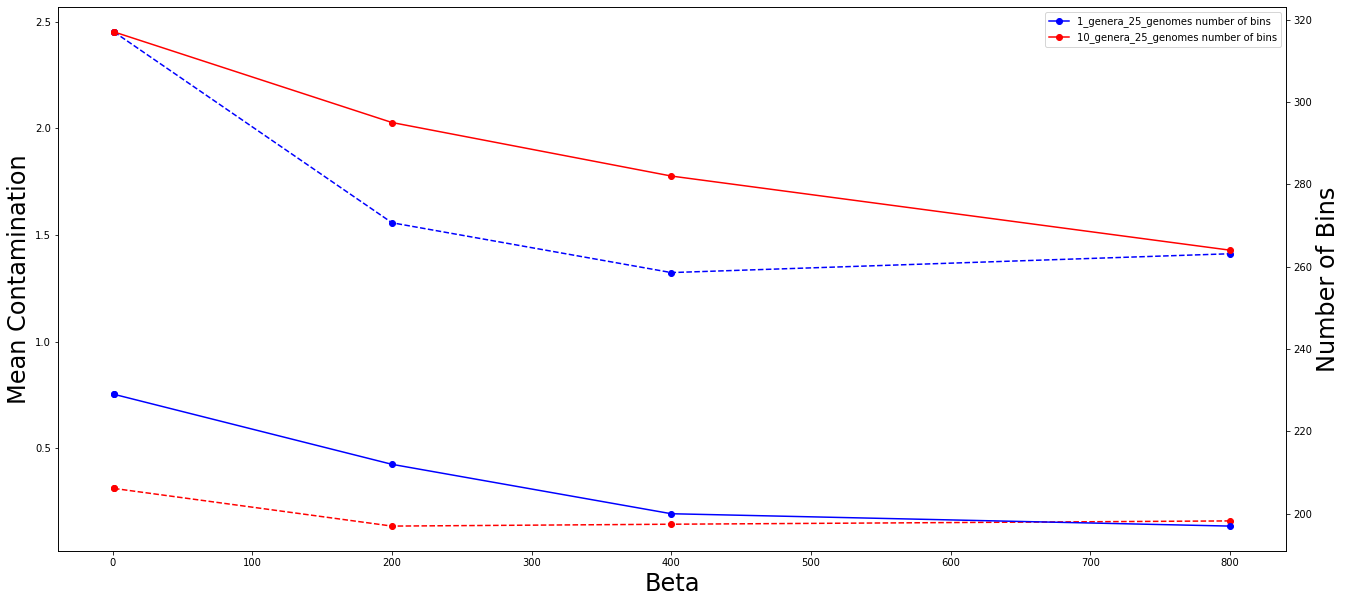

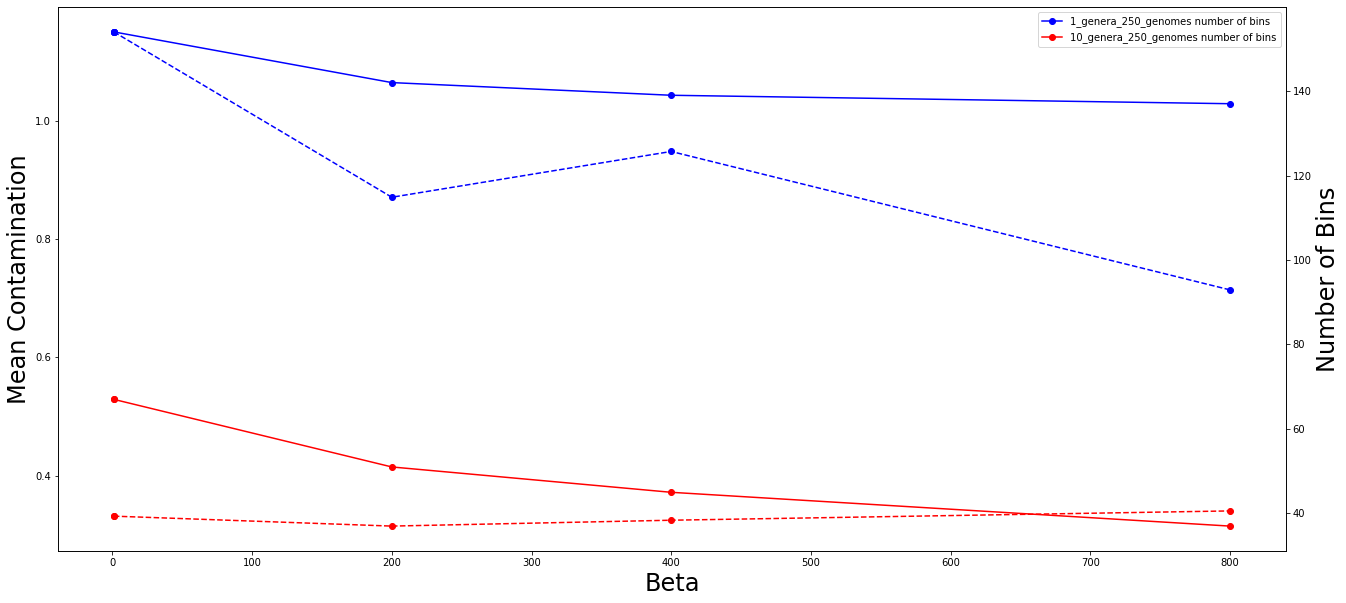

In [346]:
experiment_stats_all = pd.concat([pd.read_csv(i, sep='\t') for i in glob.glob('experiment_beta*/experiment_stats*.tsv')])
experiment_stats_all = experiment_stats_all[experiment_stats_all['beta']<1000]
experiment_stats_all['experiment'] = experiment_stats_all['num_genera'].astype(str) + '_genera_' + experiment_stats_all['num_genomes'].astype(str) + '_genomes'
experiment_stats_all = experiment_stats_all.sort_values(by=['beta','num_genera','num_genomes'])


#fig = category_scatter(x='beta', y='mean_contamination', label_col='experiment', 
#                       data=experiment_stats_all, legend_loc='upper left')



colors = ['blue','red','green']

experiment_types = [25, 250]

for experiment_type in experiment_types:
    experiment_type_df = experiment_stats_all[(experiment_stats_all['num_genomes']==experiment_type) & (~experiment_stats_all['experiment'].str.contains('5_genera'))]
    
    #plt.figure(figsize=(22,10))
    
    fig,ax = plt.subplots(figsize=(22,10))
    
    ax.set_xlabel("Beta", fontsize=24)
    ax.set_ylabel("Mean Contamination", fontsize=24)
    
    ax2=ax.twinx()
    ax2.set_ylabel("Number of Bins", fontsize=24)

    for experiment, color in zip(experiment_type_df['experiment'].unique(), colors):
        experiment_df = experiment_type_df[experiment_type_df['experiment']==experiment]
        ax.plot(experiment_df['beta'], experiment_df['mean_contamination'], label=experiment+' mean contamination', color=color, linestyle='--', marker="o")
        ax2.plot(experiment_df['beta'], experiment_df['num_bins'], label=experiment+' number of bins', color=color, linestyle='-', marker="o")
        #plt.plot(experiment_df['beta'], experiment_df['mean_contamination'], label=experiment, color=color, linestyle='--')
        #plt.plot(experiment_df['beta'], experiment_df['num_bins'], label=experiment, color=color, linestyle='-')


    #plt.xlabel('Beta')
    #plt.ylabel('Mean Contamination')
    plt.legend(loc='upper right')
    plt.show()

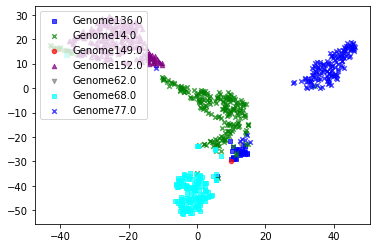

In [354]:
tsne_results = pd.read_csv('experiment_beta1/complexity_sim_10_genera_250_genomes_tsne.tsv', sep='\t')
tsne_results = tsne_results[pd.notna(tsne_results)][['0','1','genome_id']]
fig = category_scatter(x='0', y='1', label_col='genome_id', 
                       data=tsne_results, legend_loc='upper left')

In [355]:
#tsne_results = pd.read_csv('experiment_beta400/complexity_sim_10_genera_250_genomes_tsne.tsv', sep='\t')
#fig = category_scatter(x='0', y='1', label_col='genome_id', 
#                       data=tsne_results, legend_loc='lower right')

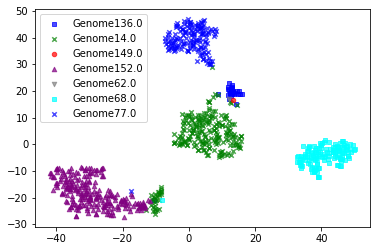

In [356]:
tsne_results = pd.read_csv('experiment_beta800/complexity_sim_10_genera_250_genomes_tsne.tsv', sep='\t')
fig = category_scatter(x='0', y='1', label_col='genome_id', 
                       data=tsne_results, legend_loc='upper left')